## Lecture 6 - Parametric Transformations; Feature Description

#### Goals
* Understand the mathematical framework for (linear) geometric transformations on images (image warping).
* Know what is possible with 2D linear transformations (scale, shear, rotation)
* Understand the motivation and math behind homogeneous coordinates.
* Know what is possible with 2D affine transformations (all of the above, plus translation)

* Understand the concept of invariance as pertains to feature detectors and feature descriptors
* Know the how and why of the MOPS feature descriptor

In [45]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Plan

* 2D linear transformations
* Affine transformations
* MOPS descriptor

### A Mathematical Digression: Geometric Transformations

Notice that I ran out of math in the last subproblem above - how do I write this down? We've reached the point where it becomes nicer to talk about geometric transformations using the language of linear algebra.

Whiteboard linear algebra review:
* A 2x2 matrix is a mapping from points to points
* You can interpret it two ways:
    * Where does it send a point?
    * What coordinate system does it translate points *from*? This is the change-of-basis vew.
* Transformations can compose (they are linear!). If you let M = AB and apply it to Mx, then B happens first, then A!
    * Sometimes this matters, since matrix multiplication doesn't commute.

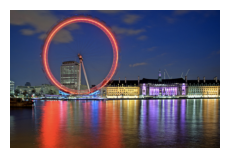

In [46]:
import geometry
ferris = imageio.imread("../data/L06/tx.png").astype(np.float32) / 255
ferris = skim.transform.rescale(ferris[:,:,:3], (0.5, 0.5, 1))

H, W = ferris.shape[:2]
util.imshow_truesize(ferris)

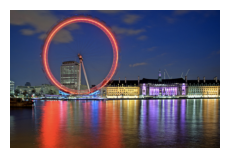

In [48]:
def warp_ferris(tx, **kwargs):
    fw = geometry.warp_cv(ferris, M, **kwargs)
    util.imshow_truesize(fw)

M = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
], dtype=np.float32)

warp_ferris(M, dsize=(W, H))

##### Homework Problems 2-5

**Important note: the coordinate system conventions here differ from the homework! Here, (0, 0) is at the top left and y points down In the HW visualizations, the origin is at the bottom left and y points up.**

2. Scale uniformly by a factor of 1.3:

   ![](../data/L06/tx1.png)

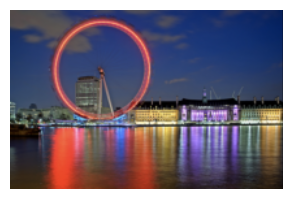

In [49]:
M = np.array([
    [1.3, 0.0],
    [0.0, 1.3]
], dtype=np.float32)

warp_ferris(M, dsize=(int(W*1.3), int(H*1.3)))

3. Scale by a factor of 2 in only the $x$ direction:

    ![](../data/L06/tx2.png)

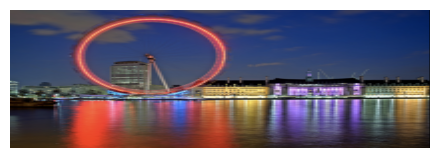

In [50]:
M = np.array([
    [2.0, 0.0],
    [0.0, 1.0]
], dtype=np.float32)

warp_ferris(M, dsize=(W*2, H))

4. Skew or *shear* the image so the top row of pixels is shifted over by 1/4 of the image's height.

    ![](../data/L06/tx3.png)

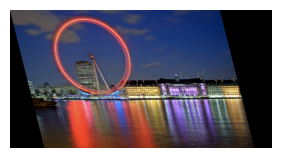

In [51]:
M = np.array([
    [1.0, 0.25],
    [0.0, 1.0]
], dtype=np.float32)

warp_ferris(M, dsize=(int(W*1.25), H))

5. Rotate the image counter-clockwise by 30 degrees:

    ![](../data/L06/tx4.png)

* Rotation matrices: to rotate $\theta$ counter-clockwise, the matrix is:
  $$
  \begin{bmatrix}
  \cos \theta & \sin \theta \\
  -\sin \theta & \cos \theta \\
  \end{bmatrix}
  $$

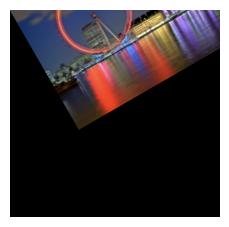

In [52]:
rad30 = np.radians(30)

M = np.array([
    [np.cos(rad30), np.sin(rad30)],
    [-np.sin(rad30), np.cos(rad30)]
], dtype=np.float32)

warp_ferris(M, dsize=(int(W), int(H*1.5)))

6. Translate the image up and right by (say) 40 pixels:
![](../data/L06/tx5.png)

Scott is the worst. This one's impossible!

Proof: no matrix can move (0, 0) to anywhere but (0, 0).

Hack: add a column! This is the same hack as the bias trick from ML.

Whiteboard: Affine transformations


Just like 2x2 linear transformations can be seen as a change of basis, affine can be seen as a **change of frame**, where the origin may also 
move. This will come back to haunt us later!

### Back to the Features!

For our feature descriptors, we agreed that a patch of pixels is more unique than a single pixel value. Let's start there, and add invariances to the following:

* Rotation
* (some) intensity shifts and scales ($I' = aI + b$, sort of)
* Scale

#### The MOPS Feature descriptor
Multi-scale oriented patches

* Get a 40x40 patch centered at the feature point
* Scale it down to 5x5
* Rotate it so the gradient direction points right
* Normalize the values by subtracting the mean and dividing by the standard deviation

  
Invariances?

* Rotation: handled by rotating the gradient direction to angle 0
* Intensity: intensity normalization handles this (ish)
* Scale: run it on a Gaussian pyramid

Let's work through how to extract the patch!

(**whiteboard**: patch extraction transformation)

array([[  1,   1],
       [  1, 106],
       [ 18, 106],
       [ 19,   7],
       [ 21,   2],
       [ 29,  22],
       [ 38, 106],
       [ 39,  10],
       [ 43,   1],
       [ 47, 105],
       [ 50,   7],
       [ 52,   2],
       [ 59,  32],
       [ 59,  84],
       [ 59, 106],
       [ 67, 104],
       [ 68,  86],
       [ 70,  29],
       [ 73,  46],
       [ 73,  72],
       [ 74,  40],
       [ 74,  56],
       [ 74,  61],
       [ 74,  78],
       [ 79,  40],
       [ 79,  56],
       [ 79,  61],
       [ 79,  73],
       [ 79,  78],
       [113,   1],
       [113,  31],
       [113,  37],
       [113,  43],
       [113,  59],
       [113,  75],
       [113,  81],
       [113, 106]])

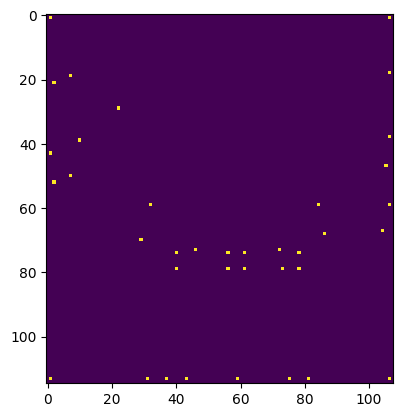

In [53]:
import features

h = imageio.imread("../data/harris_crop.jpg")
h = skim.color.rgb2gray(h.astype(np.float32) / 255)

corner_mask = features.harris_corners(h, 0.1)
plt.imshow(corner_mask)
features.get_harris_points(corner_mask).T


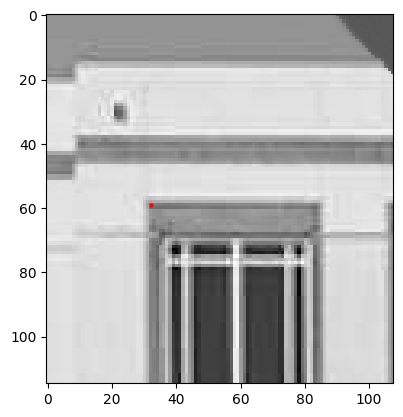

In [56]:
y, x = [59,  32]
util.imshow_gray(h)
plt.plot(x, y, 'ro', markersize=2)  # 'ro' = red circle

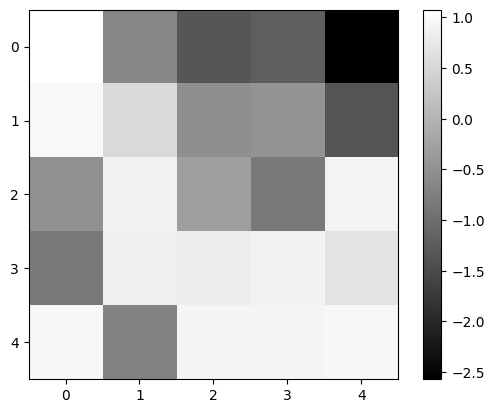

In [57]:

util.imshow_gray(features.extract_MOPS(h, (y, x)))
plt.colorbar()